In [1]:
#conda install tqdm


In [2]:
#conda install -c conda-forge imbalanced-learn

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6207049017721789933
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7612386528
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8384797704904798117
physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7095838336
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15301722550019455996
physical_device_desc: "device: 1, name: GeForce RTX 2080, pci bus id: 0000:b3:00.0, compute capability: 7.5"
]


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.callbacks import CSVLogger

In [5]:
# Read all npy files
X_data = []
y_data = []
k = 0
for f in os.scandir("./coord_total_with_yoga"):
    if f.is_file() and f.name != '.DS_Store':
        x = np.load(f, allow_pickle=True)
        print(f.name)
        print(x.shape)
        #print(x[0])
        # Remove empty coords
        x = [coords for coords in x if 1 in coords.shape]
        #print(x)
        x = np.concatenate(x)
        #print(x)
        X_data.append(x)
        y_data.extend([k]*x.shape[0])
        k += 1

X_data = np.concatenate(X_data)
#print(X_data)
y_data = np.array(y_data)

# Sanity check
print("X_data shape: {}".format(X_data.shape))
print("y_data shape: {}".format(y_data.shape))

trianglepose.npy
(67,)
Intense_Side_Stretch_Pose.npy
(25,)
Boat_Pose.npy
(50, 1, 25, 3)
Upward_Salute.npy
(21,)
wideseatedforwardbend.npy
(34, 1, 25, 3)
Fire_Log_Pose.npy
(13, 1, 25, 3)
lunge_kick_total2.npy
(148, 1, 25, 3)
chest_open_total_2.npy
(154, 1, 25, 3)
seatedforwardbend.npy
(53,)
Extended_Triangle_Pose.npy
(57,)
Staff_Pose.npy
(21, 1, 25, 3)
chest_open_total_3.npy
(226, 1, 25, 3)
mountain.npy
(155, 1, 25, 3)
lunge_kick_total3.npy
(154, 1, 25, 3)
tree.npy
(66,)
wheel.npy
(8, 1, 25, 3)
lunge_kick_total1.npy
(162, 1, 25, 3)
Dolphin_Pose.npy
(52,)
Garland_Pose.npy
(60,)
chest_open_total_4.npy
(108, 1, 25, 3)
warrior1.npy
(57,)
squat_cross_total2.npy
(176, 1, 25, 3)
mountain_climber_total3.npy
(147, 1, 25, 3)
downwarddog.npy
(106,)
Chair_Pose.npy
(60,)
chest_open_total_1.npy
(127, 1, 25, 3)
Heron_Pose.npy
(23, 1, 25, 3)
mountain_climber_total1.npy
(173, 1, 25, 3)
squat_cross_total4.npy
(90, 1, 25, 3)
plank.npy
(34,)
Lord_of_the_Dance_Pose.npy
(39, 1, 25, 3)
lunge_kick_total4.npy
(

In [6]:
def scale_transform_normalize(coords):
    """
    Parameters:
    coords (ndarray): array of (x,y,c) coordinates

    Returns:
    ndarray: coords scaled to 1x1 with center at (0,0)
    ndarray: confidence scores of each joint
    """
    coords, scores = coords[:,:,:-1], coords[:,:,-1]
    diff = coords.max(axis=1) - coords.min(axis=1)
    diff_max = np.max(diff, axis=0)
    mean = coords.mean(axis=1).reshape(coords.shape[0],1,coords.shape[-1])
    out = (coords - mean) / diff_max
    
    return out, scores

In [7]:
N,D,C = X_data.shape
print(N)
# Prepare X
X_norm, scores = scale_transform_normalize(X_data)
scores = scores.reshape((N, D, 1))
X_data = np.concatenate([X_norm, scores], axis=2)
#print(X_data)
X_data /= np.linalg.norm(X_data, axis=2)[:, :, np.newaxis]
X = []

# Prepare y
y = []

# Grab every possible combination of 2 rows
for index in tqdm(combinations(np.arange(N), 2)):
    vec_1 = X_data[index[0]]
    vec_2 = X_data[index[1]]
    X.append(np.concatenate([vec_1, vec_2]).flatten())
    y.append(int(y_data[index[0]] == y_data[index[1]]))

0it [00:00, ?it/s]

3604


6492606it [00:31, 207277.37it/s]


In [8]:
# Downsample majority class
X = np.array(X)
y = np.array(y)
trues = X[y == 1]
falses = X[y == 0]
#small_falses = resample(falses, n_samples=trues.shape[0])

#balanced_X = np.concatenate([trues, small_falses])
#balanced_y = np.concatenate([np.ones((trues.shape[0],)), np.zeros((trues.shape[0]))])
balanced_X = np.concatenate([trues, falses])
balanced_y = np.concatenate([np.ones((trues.shape[0],)), np.zeros((falses.shape[0]))])
print(trues.shape[0])
print(falses.shape[0])

198173
6294433


In [9]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='not minority', random_state=0)

In [10]:
# Split data
x_train, x_test, Y_train, Y_test = train_test_split(balanced_X, balanced_y, test_size=0.33)
print(x_train.shape)
print(Y_train.shape)

(4350046, 150)
(4350046,)


In [11]:
X_train, y_train = smote.fit_resample(x_train, Y_train)
X_test, y_test = smote.fit_resample(x_test, Y_test)


In [12]:
# # Split data
# X_train, X_test, y_train, y_test = train_test_split(balanced_X, balanced_y, test_size=0.33)

# Define network
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Activation('relu'),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dense(1),
    BatchNormalization(),
    Activation('sigmoid'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               19328     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [14]:
X_train.shape[1]

150

In [15]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 5) # 조기종료 콜백함수 정의
#hist = model.fit(X_train, Y_train, epochs=3000, batch_size=10, validation_data=(X_val, Y_val), )

In [16]:
# Train
csv_logger = CSVLogger("model_history_log.csv", append=True)
history = model.fit(x=X_train, y=y_train,
                    batch_size=128, epochs=100,
                    verbose=1, validation_split=0.33,
                    callbacks=[early_stopping])

Epoch 1/100
22770/22770 [==============================] - 210s 9ms/step - loss: 0.1901 - accuracy: 0.9453 - val_loss: 0.0606 - val_accuracy: 0.9783
Epoch 2/100
22770/22770 [==============================] - 208s 9ms/step - loss: 0.0280 - accuracy: 0.9911 - val_loss: 0.0467 - val_accuracy: 0.9848
Epoch 3/100
22770/22770 [==============================] - 206s 9ms/step - loss: 0.0213 - accuracy: 0.9933 - val_loss: 0.0463 - val_accuracy: 0.9861
Epoch 4/100
22770/22770 [==============================] - 209s 9ms/step - loss: 0.0180 - accuracy: 0.9942 - val_loss: 0.0460 - val_accuracy: 0.9831
Epoch 5/100
22770/22770 [==============================] - 210s 9ms/step - loss: 0.0160 - accuracy: 0.9948 - val_loss: 0.0360 - val_accuracy: 0.9890
Epoch 6/100
22770/22770 [==============================] - 209s 9ms/step - loss: 0.0144 - accuracy: 0.9953 - val_loss: 0.0267 - val_accuracy: 0.9905
Epoch 7/100
22770/22770 [==============================] - 209s 9ms/step - loss: 0.0131 - accuracy: 0.9956

In [17]:
history.history['accuracy']

[0.9783186316490173,
 0.9917588829994202,
 0.9934884905815125,
 0.9942776560783386,
 0.9948478937149048,
 0.9952407479286194,
 0.9956013560295105,
 0.9958555698394775,
 0.9960580468177795,
 0.9962399005889893,
 0.9964313507080078,
 0.996519148349762,
 0.9966492056846619,
 0.9967785477638245,
 0.9968701601028442,
 0.9969916343688965,
 0.997046172618866,
 0.9971669316291809,
 0.9972777962684631,
 0.9973028302192688,
 0.9973707795143127,
 0.9974057674407959,
 0.9974342584609985,
 0.9975186586380005,
 0.9975457191467285,
 0.9976068139076233,
 0.9976599812507629,
 0.9976853728294373,
 0.9977653622627258]

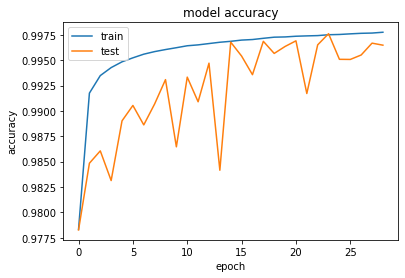

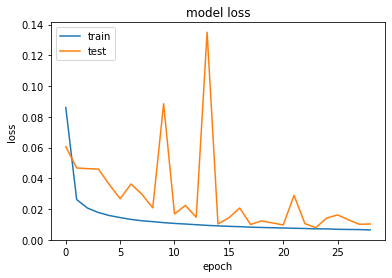

In [18]:
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AUC: 0.999


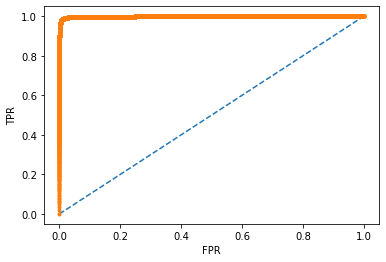

In [19]:
# Test
y_pred = model.predict(X_test)

# Check ROC, AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)

# Plot
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [20]:
from keras.models import load_model

model.save('total_coord_with_yoga_128_smote.h5')